# Real Estate Agent
The "HomeMatch" application is designed to provide personalized real estate listings based on user preferences. It leverages the capabilities of large language models (LLMs), vector databases, and semantic search to match prospective buyers with properties that best meet their needs.
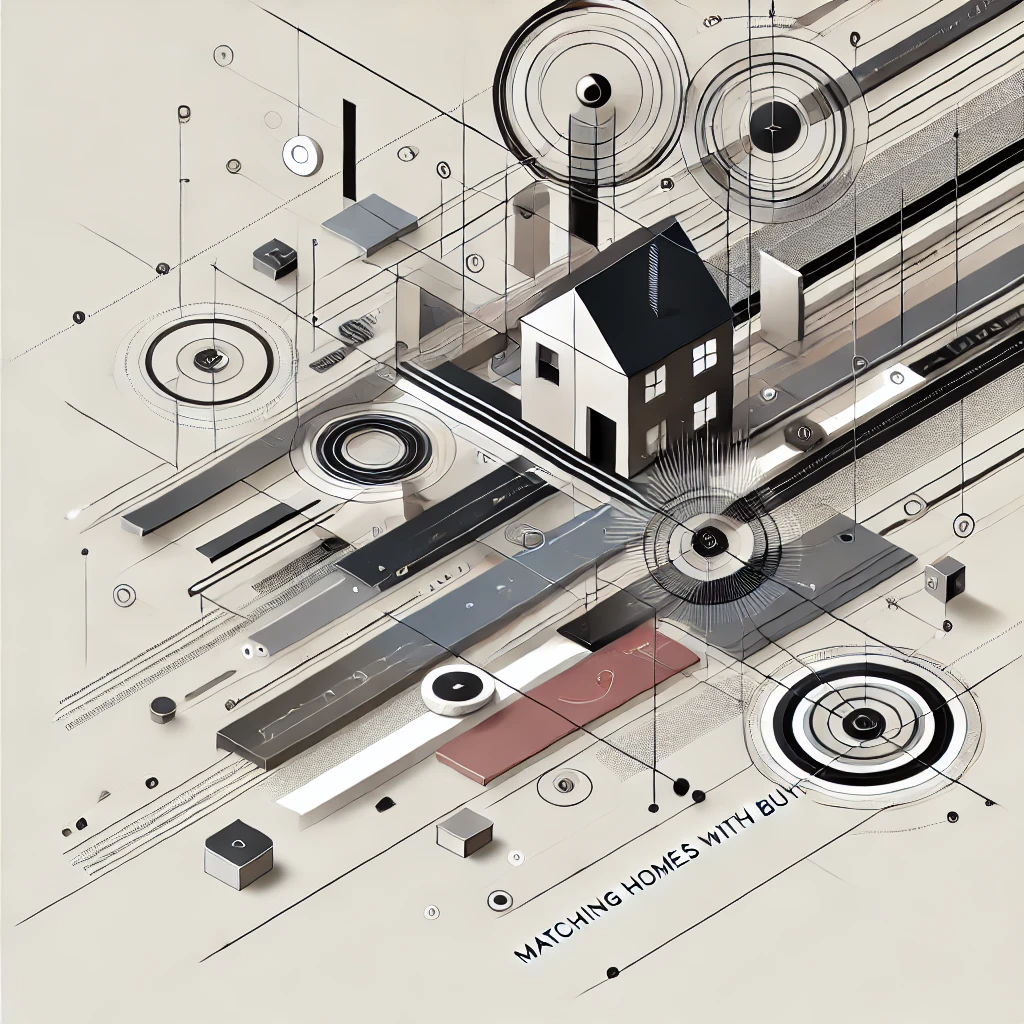

In [55]:
import pandas as pd
from openai import OpenAI
import os
import csv

from langchain_chroma import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.chat_models import ChatOpenAI
from langchain.prompts import MessagesPlaceholder, HumanMessagePromptTemplate, ChatPromptTemplate,PromptTemplate,SystemMessagePromptTemplate
from langchain.chains import ConversationChain, LLMChain
from langchain.memory import ConversationBufferMemory

from chromadb import Client
from chromadb.config import Settings

In [56]:
OPENAI_API_KEY=''
api_key = OPENAI_API_KEY

## Function definitions
### Gen AI functions

The answer_question function is designed to send a prompt to the OpenAI API, using a specified language model, and return the generated response. The function allows for customization of the system role, prompt, model, and maximum number of tokens in the response.

In [12]:
def answer_question(system_role, prompt, model, max_tokens=None):
    client = OpenAI()
    messages = [
        {"role": "system", "content": system_role},
        {"role": "user", "content": prompt},
    ]

    # Create the request parameters
    request_params = {
        "model": model,
        "messages": messages,
        "temperature": 0,
    }

    # Add max_tokens to the request if it's provided
    if max_tokens is not None:
        request_params["max_tokens"] = max_tokens

    # Send the request to the OpenAI API
    response = client.chat.completions.create(**request_params)
    response_content = response.choices[0].message.content

    print(response.usage)

    return response_content

### Processing file functions
The write_listings_to_csv function extracts CSV data from a string that contains embedded CSV content between specific markers and writes this cleaned CSV data to a file named real_estate_listings_clean.csv. This function is useful for handling and saving CSV data embedded within text blocks, particularly when such data is enclosed in specific delimiters like markdown code blocks.

In [13]:
def write_listings_to_csv(listings):
    start_marker = "```csv"
    end_marker = "```"
    
    # Find the index of the start marker
    start_index = listings.find(start_marker)
    
    # Ensure the start marker was found
    if start_index != -1:
        # Adjust start_index to the actual start of CSV content
        start_index += len(start_marker)
        
        # Find the index of the next occurrence of the end marker
        end_index = listings.find(end_marker, start_index)
        
        # Ensure the end marker was found after the start marker
        if end_index != -1:
            # Extract the CSV content between the markers
            csv_content = listings[start_index:end_index].strip()
        
            # Split the content into lines
            csv_lines = csv_content.splitlines()
        
            # Write the cleaned data to a CSV file
            with open('real_estate_listings_clean.csv', 'w', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                reader = csv.reader(csv_lines)
        
                for row in reader:
                    writer.writerow(row)
        
            print("Cleaned CSV file created successfully.")
        else:
            print("End marker not found after the start marker.")
    else:
        print("Start marker not found in the response.")

### Vector Database Functions
The load_csv_file function is designed to load a CSV file, split its contents into manageable chunks, and return these chunks for further processing. This is particularly useful when dealing with large CSV files where the content needs to be divided for more efficient processing or analysis.

The store_embeddings function is designed to generate embeddings for a collection of documents and store these embeddings in a persistent vector database. This function is particularly useful for applications like semantic search, where document embeddings need to be stored and retrieved efficiently.

In [14]:
def load_csv_file(csv_path):
    # Load the CSV file using CSVLoader
    loader = CSVLoader(file_path=csv_path, encoding="utf-8", csv_args={'delimiter': ','})
    document = loader.load()
    print(f"Loaded CSV file: {csv_path}")

    # Initialize a text splitter to divide documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    texts = text_splitter.split_documents(document)
    #print(f"Texts splitted for CSV file: {csv_path}")
    #print (texts)

    return texts 

def store_embeddings(docs,api_key):
    CHROMA_PATH = "chroma"
    embedding_model = OpenAIEmbeddings(openai_api_key=api_key, model="text-embedding-3-large")
    db = Chroma.from_documents(docs, embedding_model, persist_directory=CHROMA_PATH)
    print(f"Vector store created for CSV file")


def get_results_from_db(query,k):
    CHROMA_PATH = "chroma"
    embedding_model = OpenAIEmbeddings(openai_api_key=api_key, model="text-embedding-3-large")
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_model)
    
    # Search the DB.
    results = db.similarity_search_with_relevance_scores(query, k=k)
    return results


# Generate a set of Real Estate Listings
Use of an LLM to generate synthetic real estate listings, detailing aspects such as neighborhood, price, number of bedrooms, and a description of the property among others.

In [15]:
prompt='''
Create a detailed CSV file featuring unique real estate listings. Each listing should be systematically organized into columns, with the following attributes carefully presented, along with their respective data types:

1. **Neighborhood (Text):** Name the neighborhood where the property is located, such as "Springfield"
2. **Price (Float):** Specify the property’s market price in USD as a floating-point number, e.g., 900000.0.
3. **Bedrooms (Integer):** List the number of bedrooms in the property, e.g., 4.
4. **Bathrooms (Integer):** Indicate the total number of bathrooms as a floating-point number, e.g., 3.
5. **House Size (Float):** Provide the property’s square meters as a floating-point number, e.g., 90.0.
6. **Year Built (Integer):** Mention the year the property was built, e.g., 2015.
7. **Property Type (Text):** Indicate whether it’s a "Single-Family Home," "Condominium," "Townhouse," etc.
8. **Pool (Binary):** 1 if has pool, 0 if doesn't have pool.
9. **Lift (Binary):** 1 if has lift, 0 if doesn't have lift.
10. **Energy Efficiency (Text):** Describe any certifications or ratings related to energy efficiency, e.g., "LEED Platinum Certified," or "Energy Star Rated Appliances."
11. **Amenities (Text):** List key amenities, such as "Solar Panels," "Heated Floors," "Smart Home System," or "EV Charging Station."
12. **Description (Text):** Write a compelling paragraph (100-150 words) that highlights the property’s distinctive features, sustainable design elements, and unique amenities. Include references to the neighborhood’s character, emphasizing aspects like community spirit, green spaces, organic markets, public transportation access, and the area’s commitment to eco-friendly initiatives.

**Example Entry Format:**

Springfield,900000.0,4,3,90.0,2015,"Single-Family Home",1,0,"LEED Platinum Certified","Solar Panels, Heated Floors, Smart Home System, EV Charging Station","This stunning 4-bedroom, 3.5-bathroom home located in the eco-conscious neighborhood of Springfield is a prime example of sustainable luxury. Built in 2015, this property boasts LEED Platinum certification, ensuring top-tier energy efficiency. The spacious 90.0 sqm interior includes heated floors and a state-of-the-art smart home system. Solar panels power the home, reducing the carbon footprint, while an EV charging station caters to green transportation needs. Springfield is known for its vibrant community spirit, with numerous organic markets, parks, and easy access to public transport, all within walking distance. The neighborhood’s commitment to eco-friendly living makes this home a perfect choice for those who value sustainability and community."

**Instructions:**

- **Variety and Uniqueness:** Ensure each of the **30** listings is unique, reflecting a diverse range of neighborhoods, property types, and features. Some locations must be repeated.
- **Neighborhood Character:** Vividly describe each neighborhood's unique traits, such as local shops, community activities, environmental initiatives, and proximity to essential services.
- **Sustainable and Eco-Friendly Features:** Emphasize sustainable design elements, such as the use of renewable energy sources, recycled materials, and green building certifications.
- **Community Amenities:** Highlight nearby amenities like parks, cafes, transit hubs, schools, and green spaces that enhance the lifestyle offered by each property.
- **Formatting:** Structure the CSV with clear headers, and format each row according to the provided example, ensuring consistency and clarity.
'''

In [16]:
system_role='''Your mission is to craft the most effective and appealing property listings, ensuring they resonate with potential buyers and accurately represent the property's value.'''
MODEL="gpt-4o-mini"
re_listings=answer_question(system_role, prompt, MODEL, max_tokens=None)

CompletionUsage(completion_tokens=3319, prompt_tokens=800, total_tokens=4119)


In [17]:
write_listings_to_csv(re_listings)

Cleaned CSV file created successfully.


In [18]:
df=pd.read_csv('real_estate_listings_clean.csv')
df

,Neighborhood,Price,Bedrooms,Bathrooms,House Size,Year Built,Property Type,Pool,Lift,Energy Efficiency,Amenities,Description
0,Springfield,900000.0,4,3,90.0,2015,Single-Family Home,1,0,LEED Platinum Certified,"Solar Panels, Heated Floors, Smart Home System...","This stunning 4-bedroom, 3.5-bathroom home loc..."
1,Greenwood,750000.0,3,2,85.0,2018,Condominium,0,1,Energy Star Rated,"Rooftop Garden, Fitness Center, Smart Home System","Nestled in the heart of Greenwood, this modern..."
2,Lakeside,1200000.0,5,4,150.0,2010,Single-Family Home,1,0,LEED Gold Certified,"Solar Panels, Home Office, Large Backyard",Experience lakeside living in this exquisite 5...
3,Downtown,950000.0,2,2,70.0,2021,Condominium,0,1,Energy Star Rated,"Smart Home System, Rooftop Pool, Gym","This chic 2-bedroom, 2-bathroom condominium in..."
4,Maplewood,680000.0,3,2,95.0,2016,Townhouse,1,0,LEED Silver Certified,"Solar Panels, Community Garden, Play Area","Welcome to this charming 3-bedroom, 2-bathroom..."
5,Hillcrest,850000.0,4,3,110.0,2019,Single-Family Home,1,0,LEED Platinum Certified,"Smart Home System, Energy Efficient Appliances...","This beautiful 4-bedroom, 3-bathroom home in H..."
6,Riverside,780000.0,3,2,80.0,2017,Condominium,0,1,Energy Star Rated,"Riverside Views, Fitness Center, Smart Home Sy...","Discover this stylish 3-bedroom, 2-bathroom co..."
7,Sunnyvale,920000.0,4,3,120.0,2014,Single-Family Home,1,0,LEED Gold Certified,"Solar Panels, Home Office, Smart Home System","This stunning 4-bedroom, 3-bathroom home in Su..."
8,Cedar Grove,800000.0,3,2,100.0,2015,Townhouse,1,0,LEED Silver Certified,"Community Garden, Solar Panels, Smart Home System","This delightful 3-bedroom, 2-bathroom townhous..."
9,Westwood,1100000.0,5,4,140.0,2012,Single-Family Home,1,0,LEED Platinum Certified,"Smart Home System, Large Backyard, Solar Panels","This magnificent 5-bedroom, 4-bathroom home in..."


## Storing listings in a Vector Database (Chroma)

When building the "HomeMatch" application, we need to store and efficiently search through property listings. Instead of storing them as plain text, we convert these listings into a form that captures their meaning, known as "embeddings." These embeddings allow us to quickly find listings that match a user's preferences based on the underlying content rather than just keywords. To manage these embeddings, we use a vector database like ChromaDB.

Here's a breakdown of the key steps:

Loading the CSV File: We first load the real estate listings from a CSV file. The load_csv_file function handles this task.
This function reads the CSV file and prepares the data for further processing.

Since property descriptions can be lengthy, we split them into smaller, manageable chunks. This helps the system process and search through the text more effectively.

The text_splitter part of the code does this by breaking down the text into sections of up to 1,000 characters, with a small overlap between sections to maintain context. Once the text is prepared, we convert these chunks of text into embeddings. Embeddings are numerical representations of the text that capture the meaning and context of the listings.

The store_embeddings function is responsible for this conversion. It uses an AI model to generate these embeddings and then stores them in a vector database (ChromaDB).

Finally, the embeddings are saved in ChromaDB, creating a "vector store" that allows for efficient searching.

In [19]:
csv_path='real_estate_listings_clean.csv'
docs=load_csv_file(csv_path)

Loaded CSV file: real_estate_listings_clean.csv


In [20]:
store_embeddings(docs, api_key)

C:\Python310\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


Vector store created for CSV file


###  Building the User Preference Interface
To make the "HomeMatch" application intuitive and easy to use, we’ve developed a chatbot that helps collect all the necessary information directly from you—the user. Instead of filling out long forms or navigating complicated menus, you can simply chat with the bot, which will guide you through the process of specifying your preferences for a new home.

In [46]:
system_template =  '''
You are an AI assistant with the task of gathering essential details from a customer interested in purchasing a new property.

Purpose of the Conversation:
Begin by briefly explaining that the goal of this conversation is to understand the customer's preferences and needs to help recommend the best real estate options.

Questions to Ask:
Your objective is to gather answers to the following questions:

-What is your preferred location?
-How many rooms do you need?
-What is your preferred house size?
-Are there any amenities you would like?
-What is your budget?

Guidelines for Interaction:
-Summarize and Confirm: Once all details are gathered, thank the customer, summarize the information provided, and explain how it will help in recommending the best property options.
-End of Interaction: After collecting all the necessary details, summarize the key information to recommend the best offer. Conclude the summary by including the phrase '<EOC>' to signify the conclusion.

Current Conversation:
{content}
Human: {messages}
AI Assistant:'''

In [47]:
chat = ChatOpenAI()
memory = ConversationBufferMemory(memory_key="messages", return_messages=True)

prompt = ChatPromptTemplate(
    input_variables=["content", "messages"],
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        MessagesPlaceholder(variable_name="messages"),
        HumanMessagePromptTemplate.from_template("{content}")
    ]
)

chain = LLMChain(llm=chat, prompt=prompt, memory=memory)

In [48]:
prompt_template_str = """
Answer the question based only on the following context:

{context}

---

Given the context provided above, craft a response that not only answers the question {question},
but also ensures that your explanation is distinct, captivating, and customized to align with the specified preferences.
Strive to present your insights in a manner that resonates with the audience's interests and requirements
"""
prompt_template = ChatPromptTemplate.from_template(prompt_template_str)


#### Example 1

In [49]:
end_seq = '<EOC>'

# Start the conversation with the AI Assistant asking the first question
initial_prompt = system_template
# Run the initial prompt to start the conversation
result = chain({"content": initial_prompt})
print(result["text"])

while True:
    content = input(">> ")
    result = chain({"content": content})
    print(result["text"])
    
    # Check if the conversation has ended
    if end_seq in result["text"]:
        # Retrieve information from ChromaDB
        query = memory.chat_memory.messages[-1].content.replace(end_seq, '')
        results= get_results_from_db(query,5)
        context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
        
        data = []
        for doc, score in results:
            row = {
                "relevance_score": score,
                "row": doc.metadata.get("row"),
                "source": doc.metadata.get("source"),
                "content": doc.page_content
            }
            data.append(row)
            
        system_role='You are a RE expert and your mission is to provide me with the houses that matches my requirements'
        prompt = prompt_template.format(context=context_text, question=query)
        answer=answer_question(system_role, prompt, MODEL, max_tokens=None)
       
        # Present the retrieved information

        print("-------------------------------------------------------------")
        print("-------------------------------------------------------------")
        print("-------------------------------------------------------------")
        
        print (answer)
                
        break  # Exit the loop after retrieving information

I'm here to assist you in finding the perfect property. Could you please provide me with the following details:
1. What is your preferred location?
2. How many rooms do you need?
3. What is your preferred house size?
4. Are there any specific amenities you would like?
5. What is your budget?


>>  not prefered location, but i need 4 rooms and must have a pool, i am rich so no no budget constrains


Thank you for providing your preferences. Based on the information you've shared, you are looking for a property with 4 rooms and a pool, and you have no budget constraints. This will help me recommend suitable properties for you. <EOC>
CompletionUsage(completion_tokens=530, prompt_tokens=1080, total_tokens=1610)
-------------------------------------------------------------
-------------------------------------------------------------
-------------------------------------------------------------
Thank you for sharing your preferences! Based on your criteria for a property with 4 bedrooms and a pool, I have some captivating options that align perfectly with your desires. 

1. **Crescent Neighborhood**: Priced at **$950,000**, this stunning 4-bedroom, 3-bathroom home, built in **2015**, is a blend of luxury and sustainability, featuring **LEED Gold certification**. With a spacious **130.0 sqm** layout, it includes a **smart home system** and a **large backyard**, ideal for outdoor gather

#### Example 2

In [50]:
end_seq = '<EOC>'

# Start the conversation with the AI Assistant asking the first question
initial_prompt = system_template
# Run the initial prompt to start the conversation
result = chain({"content": initial_prompt})
print(result["text"])

while True:
    content = input(">> ")
    result = chain({"content": content})
    print(result["text"])
    
    # Check if the conversation has ended
    if end_seq in result["text"]:
        # Retrieve information from ChromaDB
        query = memory.chat_memory.messages[-1].content.replace(end_seq, '')
        results= get_results_from_db(query,5)
        context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
        
        data = []
        for doc, score in results:
            row = {
                "relevance_score": score,
                "row": doc.metadata.get("row"),
                "source": doc.metadata.get("source"),
                "content": doc.page_content
            }
            data.append(row)
            
        system_role='You are a RE expert and your mission is to provide me with the houses that matches my requirements'
        prompt = prompt_template.format(context=context_text, question=query)
        answer=answer_question(system_role, prompt, MODEL, max_tokens=None)
       
        # Present the retrieved information

        print("-------------------------------------------------------------")

        print (answer)
                
        break  # Exit the loop after retrieving information

I'm here to assist you in finding the perfect property. Could you please provide me with the following details:
1. What is your preferred location?
2. How many rooms do you need?
3. What is your preferred house size?
4. Are there any specific amenities you would like?
5. What is your budget?


>>  The house must be located in a place that starts with "S", must have a garden, im not worried about the budget but im very worried about the environment so better if it is efficient in term of energy


Thank you for your preferences. You are looking for a property located in a place that starts with "S", with a garden, and high energy efficiency. Since budget is not a concern, this information will help me recommend environmentally friendly properties with your desired features. <EOC>
CompletionUsage(completion_tokens=324, prompt_tokens=1036, total_tokens=1360)
-------------------------------------------------------------
Thank you for sharing your preferences! Based on your desire for a property located in a neighborhood that starts with "S," featuring a garden and high energy efficiency, I have a couple of captivating options that align perfectly with your criteria.

1. **Southtown Townhouse**: This charming 3-bedroom, 2-bathroom townhouse, built in 2016, is a delightful find in the friendly neighborhood of Southtown. With LEED Silver certification, it embodies a commitment to sustainability while offering a nurturing environment for families. The 90.0 sqm home includes solar panel

Our chatbot serves as a personal assistant that chats with you to gather all the information needed to find your ideal home. By asking relevant questions and collecting your preferences in a natural and interactive way, it ensures that the "HomeMatch" application can provide you with the best possible property matches. This approach simplifies the search process, making it easy and convenient for you to find your dream home.